### Importing Libraries


In [1]:
# Importing required libraries
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import os
import cv2
from keras import layers
from keras import activations
import numpy as np
import datetime
import pandas as pd
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.optimizers import Adam

### Loading the data

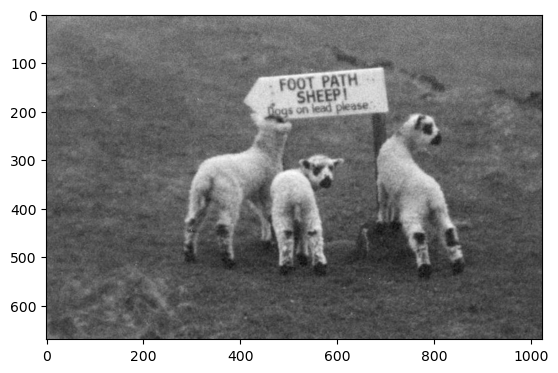

In [2]:
data = "./dataset"
classes = ["alpaca", "not alpaca"]

for i in classes:
  path = os.path.join(data, i)
  for img in os.listdir(path):  
    img_arr = cv2.imread(os.path.join(path,img), cv2.IMREAD_GRAYSCALE)
    plt.imshow(img_arr, cmap = "gray")  
    plt.show() 
    break
  break  

### Resizing the Data

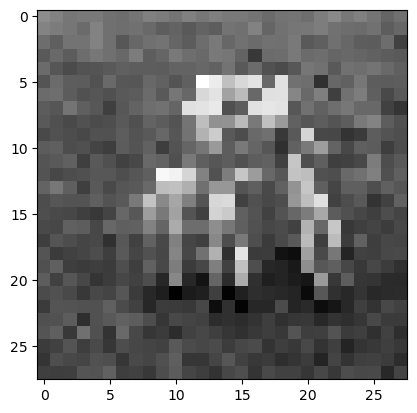

In [3]:
# Resizing of the image
new_arr = cv2.resize(img_arr, (28,28))
# Checking image distortion after resizing
plt.imshow(new_arr, cmap = 'gray')
plt.show()

### Splitting The Data

In [4]:
# Initialising dataset
dataset= []
for i in classes:
    path = os.path.join(data, i)
    
    # Assigning number to classes using their index, i.e., alpaca = [0] not alpaca = [1]  
    Class_Num = classes.index(i) 
    for img in os.listdir(path): 
        img_arr = cv2.imread(os.path.join(path,img), cv2.IMREAD_GRAYSCALE) 
        New_Array = cv2.resize(img_arr, (28,28))
        dataset.append([New_Array, Class_Num])     

In [5]:
import random
random.shuffle(dataset) #Shuffling of data for better training
     
X = [] 
y = []

# Splitting the data into features and labels
for i, j in dataset:
    X.append(i)
    y.append(j)
X = np.array(X)  
y = np.array(y)
# Creating a copy for tradional CNN model
X_copy = np.copy(X)
# Re-shaping the images
X = np.array(X).reshape(-1, 1, 28, 28)     

In [6]:
from sklearn.model_selection import train_test_split

# Splitting the data into training and testing sets
X_trainval, X_test, y_trainval, y_test = train_test_split(X, y, test_size=0.3, random_state=10)

# Splitting the training set into training and validation sets
X_train, X_valid, y_train, y_valid = train_test_split(X_trainval, y_trainval, test_size=0.2, random_state=10)

X_train = tf.cast(X_train, tf.float32)
X_valid = tf.cast(X_valid, tf.float32)
X_test = tf.cast(X_test, tf.float32)

print(f"Total samples: {len(X)}")
print(f"Training Dataset shape: X: {X_train.shape}, y: {y_train.shape}")
print(f"Validation Dataset shape: X: {X_valid.shape}, y: {y_valid.shape}")
print(f"Testing Dataset shape: X: {X_test.shape}, y: {y_test.shape}")


Total samples: 327
Training Dataset shape: X: (182, 1, 28, 28), y: (182,)
Validation Dataset shape: X: (46, 1, 28, 28), y: (46,)
Testing Dataset shape: X: (99, 1, 28, 28), y: (99,)


### Proposed layer

In [7]:
class ProposedLayer(keras.layers.Layer):
    def __init__(self, num_filters):
        super(ProposedLayer, self).__init__()
        self.num_filters = num_filters
        
    def build(self, input_shape):
        self.w = self.add_weight(shape=(self.num_filters, input_shape[-1], input_shape[-1]),
            initializer="random_normal", trainable=True)
        
    def call(self, inputs):
        samples = tf.shape(inputs)[0]
        channels = tf.shape(inputs)[1]
        output_maps = tf.zeros((samples,self.num_filters, tf.shape(inputs)[2]-2, tf.shape(inputs)[3]-2))
        ax1 = tf.shape(output_maps)[0]
        ax2 = tf.shape(output_maps)[1]
        ax3 = tf.shape(output_maps)[2]
        ax4 = tf.shape(output_maps)[3]
        
        for n in range(ax1):
            for k in range(ax2):
                x1 = tf.constant(0)
                y1 = tf.constant(3)
                for i in range(ax3):
                    x1 = tf.constant(0) 
                    y1 = tf.constant(3) 
                    for j in range(ax4):
                        weighted_sum = tf.constant(0.0)               
                        for c in range(channels):
                            weighted_sum += tf.math.reduce_sum(tf.matmul(inputs[n, c, x1:y1, x1:y1], self.w[k, x1:y1, x1:y1]))
                            
                        sparse_tensor = tf.SparseTensor(indices=[[n, k, i, j]],
                            values=[weighted_sum],
                            dense_shape=[ax1, ax2, ax3, ax4])
                        
                        output_maps = output_maps + tf.sparse.to_dense(sparse_tensor)
                        
                        x1 += 1
                        y1 += 1
                    x1 += 1
                    y1 += 1
        self.activations = tf.reshape(output_maps, (ax1, ax2, ax3, ax4))
        return self.activations
    
    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.num_filters, input_shape[2]-2, input_shape[3]-2)
    
    def compute_mask(self, inputs, mask=None):
        return None
    
    def compute_gradients(self, loss, var_list):
        gradients = super(ProposedLayer, self).compute_gradients(loss, var_list)
        
        # Access the gradients of the layer's weights
        w_grads = gradients[0][0]
        
        # Compute the gradients of the layer's inputs
        inputs_grads = tf.zeros_like(self.activations)
        for n in range(ax1):
            for c in range(channels):
                for k in range(self.num_filters):
                    for i in range(ax3):
                        x1 = tf.constant(0)
                        y1 = tf.constant(3)
                        for j in range(ax4):
                            for x2 in range(x1, y1):
                                for y2 in range(x1, y1):
                                    inputs_grads[n, c, x2, y2] += w_grads[k, x2-x1, y2-y1] * self.activations[n, k, i, j]
                            x1 += 1
                            y1 += 1
                        x1 += 1
                        y1 += 1
    
        return [(inputs_grads, var_list[0])] if len(var_list) > 0 else [(inputs_grads,)]


### Implementing the layer with Sequential model

In [8]:
model_1 = keras.models.Sequential()
model_1.add(ProposedLayer(num_filters=5))
model_1.add(layers.Activation(activations.relu))
model_1.add(layers.MaxPooling2D(pool_size=(2, 2),strides=(2, 2)))
model_1.add(ProposedLayer(num_filters=3))
model_1.add(layers.Activation(activations.relu))
model_1.add(layers.MaxPooling2D(pool_size=(2, 2),strides=(2, 2)))
model_1.add(ProposedLayer(num_filters=2))
model_1.add(layers.Activation(activations.relu))
model_1.add(layers.Flatten())
model_1.add(layers.Dense(units=16, activation="relu"))
model_1.add(layers.Dense(units=1, activation="softmax"))



### Compiling and Running the model

In [9]:
# Compile the model
model_1.compile(loss='binary_crossentropy', optimizer='SGD', metrics=['accuracy'])

# Define the TensorBoard callback
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

# Train the model on the training data
history = model_1.fit(X_train, y_train, epochs=5, batch_size=None, validation_data=(X_valid, y_valid), callbacks=[tensorboard_callback])

# Evaluate the model on the testing data
test_loss, test_acc = model_1.evaluate(X_test, y_test)
print('Test accuracy:', test_acc)


Epoch 1/5


C:\Users\Rutwik\anaconda3\lib\site-packages\keras\engine\sequential.py:458: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_configs.append(serialization.serialize_keras_object(layer))


6/6 [==============================] - 445s 74s/step - loss: 0.6888 - accuracy: 0.5989 - val_loss: 0.7054 - val_accuracy: 0.5217
Epoch 2/5
6/6 [==============================] - 524s 90s/step - loss: 0.6830 - accuracy: 0.5989 - val_loss: 0.6952 - val_accuracy: 0.5217
Epoch 3/5
6/6 [==============================] - 510s 86s/step - loss: 0.6756 - accuracy: 0.5989 - val_loss: 0.7043 - val_accuracy: 0.5217
Epoch 4/5
6/6 [==============================] - 586s 99s/step - loss: 0.6770 - accuracy: 0.5989 - val_loss: 0.7140 - val_accuracy: 0.5217
Epoch 5/5
4/4 [==============================] - 102s 21s/step - loss: 0.6911 - accuracy: 0.5253
Test accuracy: 0.5252525210380554


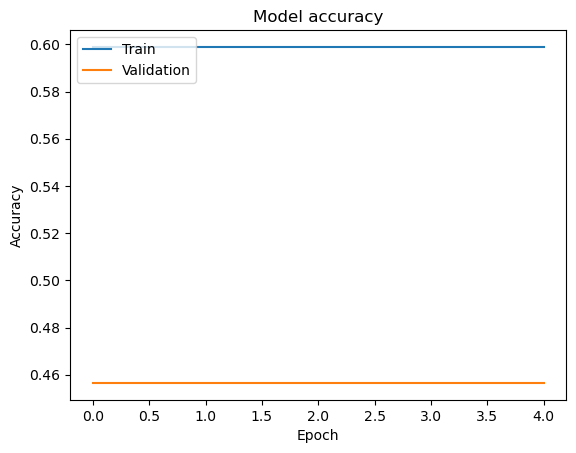

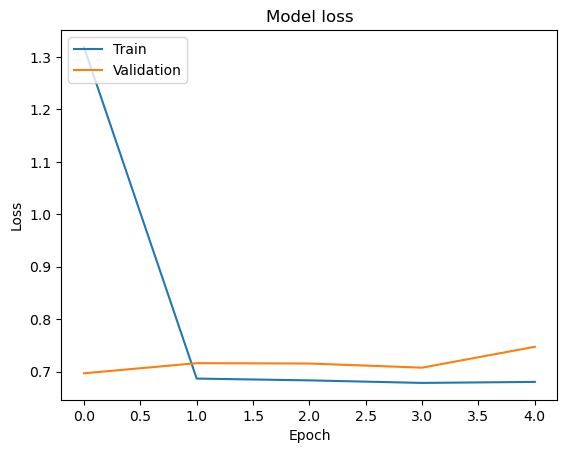

In [10]:
# Plot the training and validation accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()
# Plot the training and validation loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

### Change in Hyperparameter 1

Epoch 1/5
23/23 [==============================] - 203s 9s/step - loss: 0.6913 - accuracy: 0.5989 - val_loss: 0.7006 - val_accuracy: 0.4565
Epoch 2/5
23/23 [==============================] - 196s 9s/step - loss: 0.6811 - accuracy: 0.5989 - val_loss: 0.7068 - val_accuracy: 0.4565
Epoch 3/5
23/23 [==============================] - 197s 9s/step - loss: 0.6780 - accuracy: 0.5989 - val_loss: 0.7103 - val_accuracy: 0.4565
Epoch 4/5
23/23 [==============================] - 195s 9s/step - loss: 0.6770 - accuracy: 0.5989 - val_loss: 0.7146 - val_accuracy: 0.4565
Epoch 5/5
4/4 [==============================] - 44s 10s/step - loss: 0.6878 - accuracy: 0.5556
Test accuracy: 0.5555555820465088


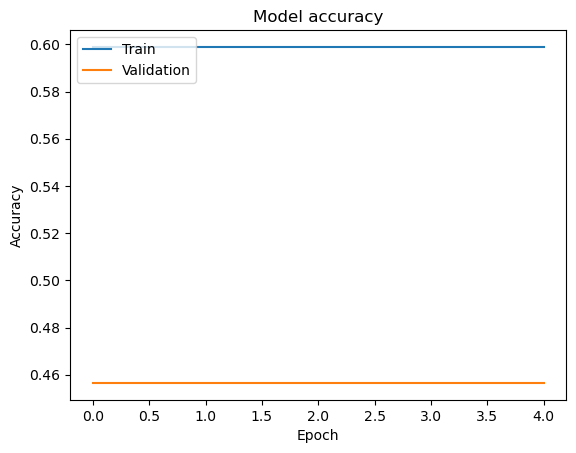

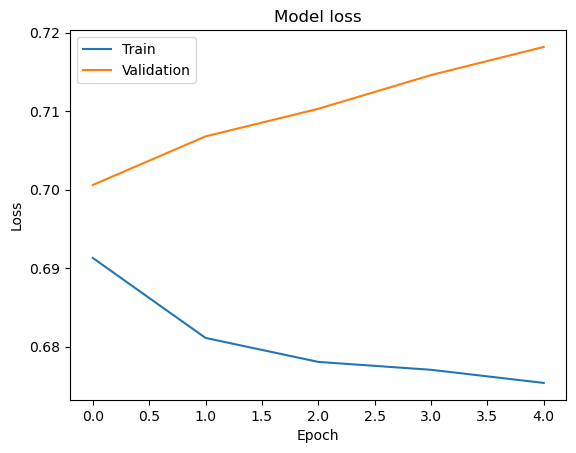

In [11]:
learning_rate = 0.05
optimizer = SGD(learning_rate=learning_rate)
model_1.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

#hyper 1
history_1 = model_1.fit(X_train, y_train, epochs=5, batch_size=8, validation_data=(X_valid, y_valid), callbacks=[tensorboard_callback])

# Evaluate the model on the testing data
test_loss, test_acc = model_1.evaluate(X_test, y_test)
print('Test accuracy:', test_acc)

# Plot the training and validation accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()
# Plot the training and validation loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

### Change in Hyperparameter 2

Epoch 1/5
23/23 [==============================] - 197s 8s/step - loss: 0.6780 - accuracy: 0.5989 - val_loss: 0.7229 - val_accuracy: 0.4565
Epoch 2/5
23/23 [==============================] - 191s 8s/step - loss: 0.6748 - accuracy: 0.5989 - val_loss: 0.7339 - val_accuracy: 0.4565
Epoch 3/5
23/23 [==============================] - 192s 8s/step - loss: 0.6751 - accuracy: 0.5989 - val_loss: 0.7361 - val_accuracy: 0.4565
Epoch 4/5
23/23 [==============================] - 192s 8s/step - loss: 0.6806 - accuracy: 0.5989 - val_loss: 0.7331 - val_accuracy: 0.4565
Epoch 5/5
4/4 [==============================] - 50s 11s/step - loss: 0.6877 - accuracy: 0.5556
Test accuracy: 0.5555555820465088


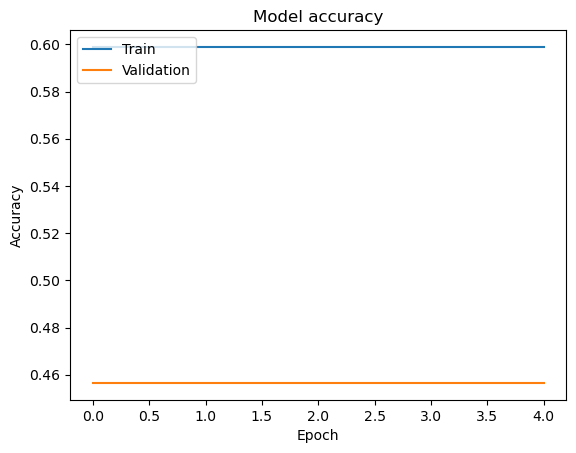

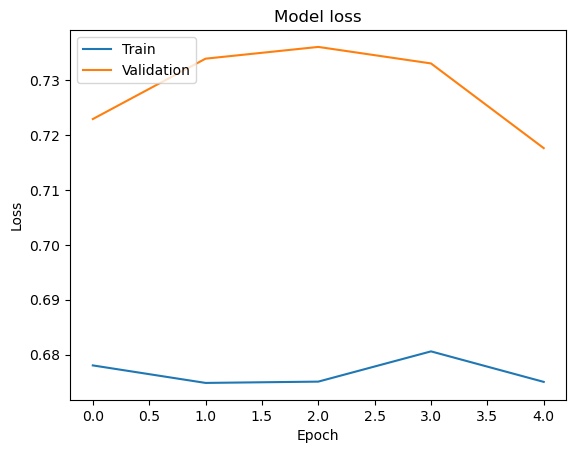

In [12]:
learning_rate = 0.05
optimizer = Adam(learning_rate=learning_rate)
model_1.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

#hyper 2
history = model_1.fit(X_train, y_train, epochs=5, batch_size=8, validation_data=(X_valid, y_valid), callbacks=[tensorboard_callback])

# Evaluate the model on the testing data
test_loss, test_acc = model_1.evaluate(X_test, y_test)
print('Test accuracy:', test_acc)

# Plot the training and validation accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()
# Plot the training and validation loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

### Change in Hyperparameter 3

Epoch 1/5
12/12 [==============================] - 219s 18s/step - loss: 0.6749 - accuracy: 0.5989 - val_loss: 0.7193 - val_accuracy: 0.4565
Epoch 2/5
12/12 [==============================] - 215s 18s/step - loss: 0.6753 - accuracy: 0.5989 - val_loss: 0.7293 - val_accuracy: 0.4565
Epoch 3/5
12/12 [==============================] - 216s 18s/step - loss: 0.6753 - accuracy: 0.5989 - val_loss: 0.7395 - val_accuracy: 0.4565
Epoch 4/5
12/12 [==============================] - 226s 19s/step - loss: 0.6736 - accuracy: 0.5989 - val_loss: 0.7300 - val_accuracy: 0.4565
Epoch 5/5
4/4 [==============================] - 58s 13s/step - loss: 0.6900 - accuracy: 0.5556
Test accuracy: 0.5555555820465088


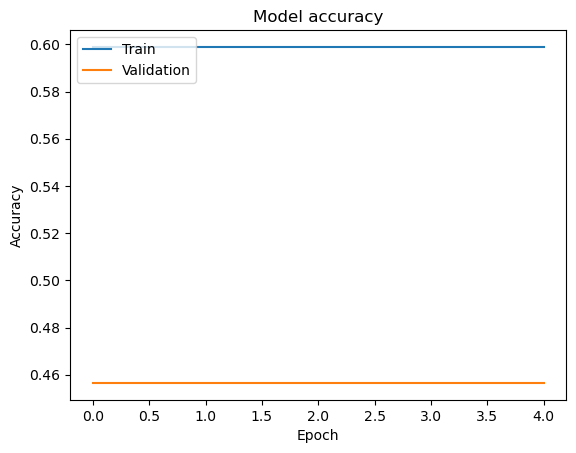

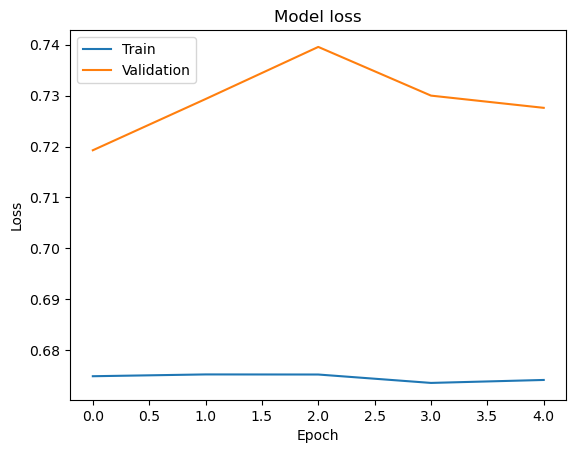

In [13]:
learning_rate = 0.1
optimizer = SGD(learning_rate=learning_rate)
#hyper 3
history = model_1.fit(X_train, y_train, epochs=5, batch_size=16, validation_data=(X_valid, y_valid), callbacks=[tensorboard_callback])

# Evaluate the model on the testing data
test_loss, test_acc = model_1.evaluate(X_test, y_test)
print('Test accuracy:', test_acc)

# Plot the training and validation accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()
# Plot the training and validation loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

### Change in Hyperparameter 4

Epoch 1/5
12/12 [==============================] - 255s 21s/step - loss: 0.6740 - accuracy: 0.5989 - val_loss: 0.7381 - val_accuracy: 0.4565
Epoch 2/5
12/12 [==============================] - 235s 20s/step - loss: 0.6751 - accuracy: 0.5989 - val_loss: 0.7434 - val_accuracy: 0.4565
Epoch 3/5
12/12 [==============================] - 259s 22s/step - loss: 0.6757 - accuracy: 0.5989 - val_loss: 0.7292 - val_accuracy: 0.4565
Epoch 4/5
12/12 [==============================] - 264s 22s/step - loss: 0.6737 - accuracy: 0.5989 - val_loss: 0.7301 - val_accuracy: 0.4565
Epoch 5/5
4/4 [==============================] - 63s 14s/step - loss: 0.6892 - accuracy: 0.5556
Test accuracy: 0.5555555820465088


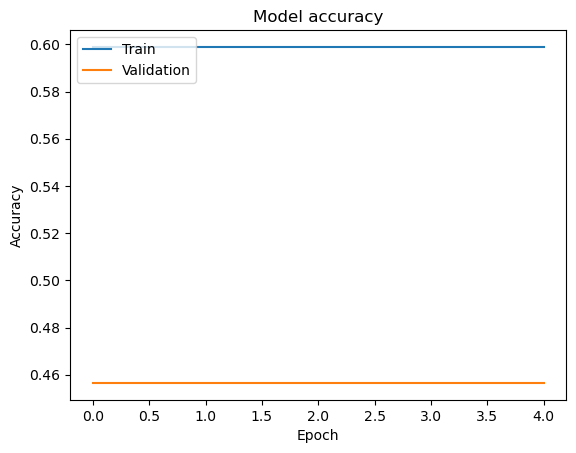

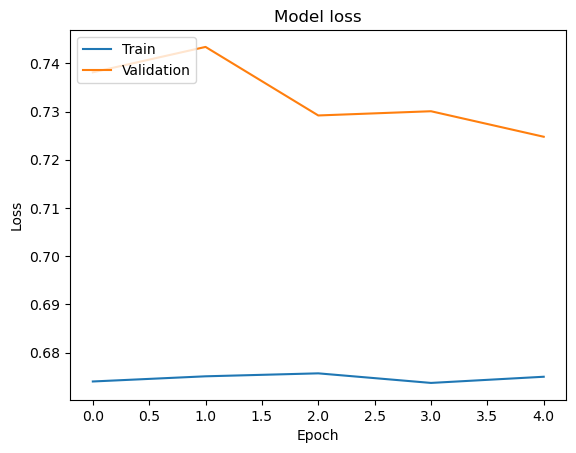

In [14]:
learning_rate = 0.01
optimizer = Adam(learning_rate=learning_rate)

#hyper 4
history = model_1.fit(X_train, y_train, epochs=5, batch_size=16, validation_data=(X_valid, y_valid), callbacks=[tensorboard_callback])

# Evaluate the model on the testing data
test_loss, test_acc = model_1.evaluate(X_test, y_test)
print('Test accuracy:', test_acc)

# Plot the training and validation accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot the training and validation loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

### Changing Width of the model

In [23]:
#width
model_1 = keras.models.Sequential()
model_1.add(ProposedLayer(num_filters=6))
model_1.add(layers.Activation(activations.relu))
model_1.add(layers.MaxPooling2D(pool_size=(2, 2),strides=(2, 2)))
model_1.add(ProposedLayer(num_filters=4))
model_1.add(layers.Activation(activations.relu))
model_1.add(layers.MaxPooling2D(pool_size=(2, 2),strides=(2, 2)))
model_1.add(ProposedLayer(num_filters=2))
model_1.add(layers.Activation(activations.relu))
model_1.add(layers.Flatten())
model_1.add(layers.Dense(units=16, activation="relu"))
model_1.add(layers.Dense(units=1, activation="softmax"))


In [24]:
learning_rate = 0.01
optimizer = SGD(learning_rate=learning_rate)
model_1.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

#hyper 1
history_1 = model_1.fit(X_train, y_train, epochs=5, batch_size=8, validation_data=(X_valid, y_valid), callbacks=[tensorboard_callback])

# Evaluate the model on the testing data
test_loss, test_acc = model_1.evaluate(X_test, y_test)
print('Test accuracy:', test_acc)

Epoch 1/5
23/23 [==============================] - 388s 17s/step - loss: 7.5581 - accuracy: 0.5659 - val_loss: 0.6928 - val_accuracy: 0.5870
Epoch 2/5
23/23 [==============================] - 384s 17s/step - loss: 0.6926 - accuracy: 0.5659 - val_loss: 0.6916 - val_accuracy: 0.5870
Epoch 3/5
23/23 [==============================] - 462s 20s/step - loss: 0.6917 - accuracy: 0.5659 - val_loss: 0.6904 - val_accuracy: 0.5870
Epoch 4/5
23/23 [==============================] - 465s 20s/step - loss: 0.6908 - accuracy: 0.5659 - val_loss: 0.6894 - val_accuracy: 0.5870
Epoch 5/5
4/4 [==============================] - 97s 21s/step - loss: 0.6903 - accuracy: 0.5556
Test accuracy: 0.5555555820465088


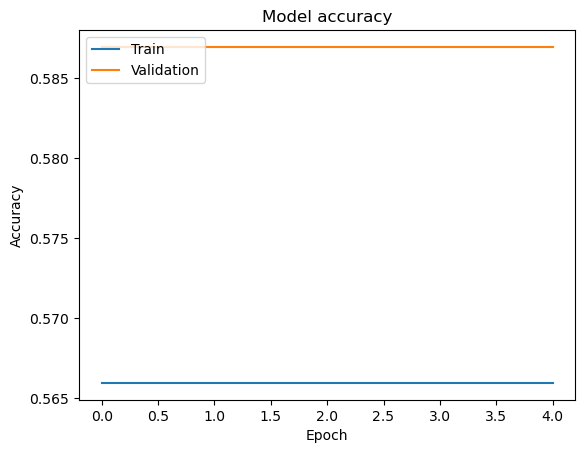

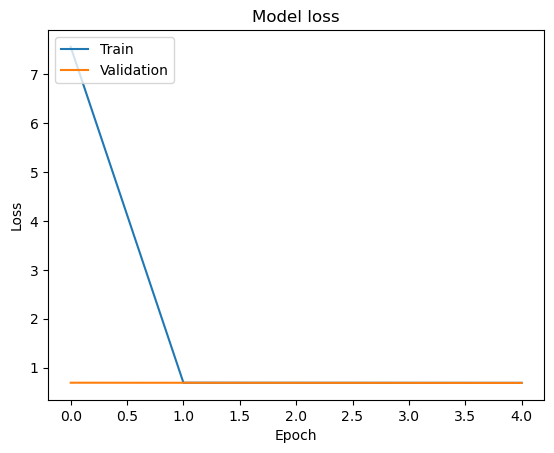

In [25]:
# Plot the training and validation accuracy
plt.plot(history_1.history['accuracy'])
plt.plot(history_1.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot the training and validation loss
plt.plot(history_1.history['loss'])
plt.plot(history_1.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

### Changing the Depth of the model

In [20]:
#Depth
model_2 = keras.models.Sequential()
model_2.add(ProposedLayer(num_filters=6))
model_2.add(layers.Activation(activations.relu))
model_2.add(layers.MaxPooling2D(pool_size=(2, 2),strides=(2, 2)))
model_2.add(layers.Flatten())
model_2.add(layers.Dense(units=16, activation="relu"))
model_2.add(layers.Dense(units=1, activation="softmax"))


Epoch 1/5
23/23 [==============================] - 225s 10s/step - loss: 127805.6016 - accuracy: 0.5659 - val_loss: 530.6401 - val_accuracy: 0.5870
Epoch 2/5
23/23 [==============================] - 236s 10s/step - loss: 0.6816 - accuracy: 0.5659 - val_loss: 530.6393 - val_accuracy: 0.5870
Epoch 3/5
23/23 [==============================] - 257s 11s/step - loss: 0.6807 - accuracy: 0.5659 - val_loss: 530.6385 - val_accuracy: 0.5870
Epoch 4/5
23/23 [==============================] - 229s 10s/step - loss: 0.6800 - accuracy: 0.5659 - val_loss: 530.6375 - val_accuracy: 0.5870
Epoch 5/5
4/4 [==============================] - 66s 15s/step - loss: 938.8556 - accuracy: 0.5556
Test accuracy: 0.5555555820465088


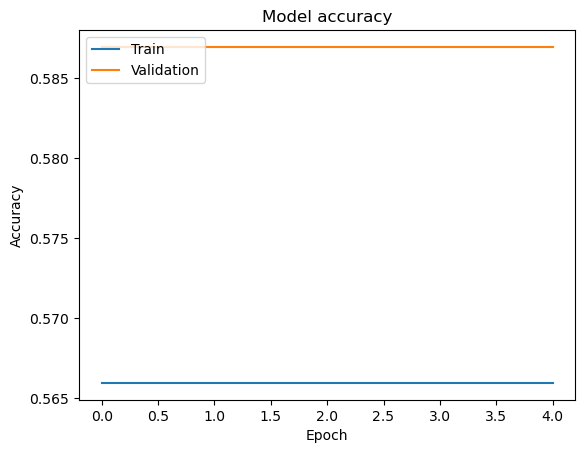

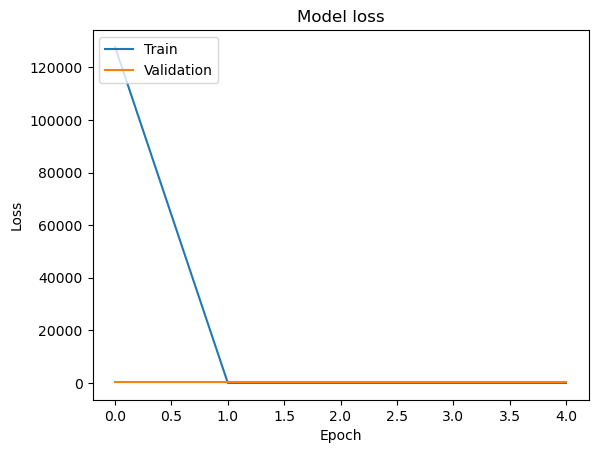

In [22]:
learning_rate = 0.01
optimizer = SGD(learning_rate=learning_rate)
model_2.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])


#hyper 1
history_1 = model_2.fit(X_train, y_train, epochs=5, batch_size=8, validation_data=(X_valid, y_valid), callbacks=[tensorboard_callback])

# Evaluate the model on the testing data
test_loss, test_acc = model_2.evaluate(X_test, y_test)
print('Test accuracy:', test_acc)

# Plot the training and validation accuracy
plt.plot(history_1.history['accuracy'])
plt.plot(history_1.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot the training and validation loss
plt.plot(history_1.history['loss'])
plt.plot(history_1.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

### Implementing the Traditional CNN Model

In [26]:
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Dense, Dropout , Activation , Flatten , Conv2D , MaxPooling2D

X_CNN = X_copy.reshape(-1,28,28,1)
# Splitting the data into training and testing sets
X_train_CNN, X_test_CNN, y_train_CNN, y_test_CNN = train_test_split(X_CNN, y, test_size=0.3, random_state=10)

# Splitting the training set into training and validation sets  
X_train_CNN, X_val_CNN, y_train_CNN, y_val_CNN = train_test_split(X_train_CNN, y_train_CNN, test_size=0.2, random_state=10)

X_train_CNN = tf.cast(X_train_CNN, tf.float32)
X_val_CNN = tf.cast(X_val_CNN, tf.float32)
X_test_CNN = tf.cast(X_test_CNN, tf.float32)

print(f"Total samples: {len(X_CNN)}")
print(f"Training Dataset shape: X: {X_train_CNN.shape}, y: {y_train.shape}")
print(f"Validation Dataset shape: X: {X_val_CNN.shape}, y: {y_valid.shape}")
print(f"Testing Dataset shape: X: {X_test_CNN.shape}, y: {y_test.shape}")

Total samples: 327
Training Dataset shape: X: (182, 28, 28, 1), y: (182,)
Validation Dataset shape: X: (46, 28, 28, 1), y: (46,)
Testing Dataset shape: X: (99, 28, 28, 1), y: (99,)


In [27]:
CNN_model = Sequential() 
shape=(28, 28, 1)
CNN_model.add(Conv2D(5,   kernel_size = (3,3)   , input_shape = shape))
CNN_model.add(Activation("relu")) 
CNN_model.add(MaxPooling2D(pool_size= (2,2))) 
CNN_model.add(Conv2D(3 , kernel_size = (3,3) ))
CNN_model.add(Activation("relu"))  
 
CNN_model.add(MaxPooling2D()) 
CNN_model.add(Conv2D(filters=2, kernel_size=(3,3)))
CNN_model.add(Activation("relu"))  

CNN_model.add(Flatten()) 

CNN_model.add(Activation('relu'))
CNN_model.add(Dense(units=16 , activation='relu'))

CNN_model.add(Dense(units=1) )
CNN_model.add(Activation('softmax'))

CNN_model.compile(optimizer= tf.keras.optimizers.SGD( learning_rate = 0.01) , loss='binary_crossentropy', metrics=['accuracy'])
CNN_model.summary()
history = CNN_model.fit(X_train_CNN, y_train_CNN , batch_size = None, epochs=5 , validation_data=(X_val_CNN , y_val_CNN))

test_loss, test_acc = CNN_model.evaluate(X_test_CNN,  y_test_CNN)

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 5)         50        
                                                                 
 activation_10 (Activation)  (None, 26, 26, 5)         0         
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 13, 13, 5)        0         
 2D)                                                             
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 3)         138       
                                                                 
 activation_11 (Activation)  (None, 11, 11, 3)         0         
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 5, 5, 3)          0         
 2D)                                                  

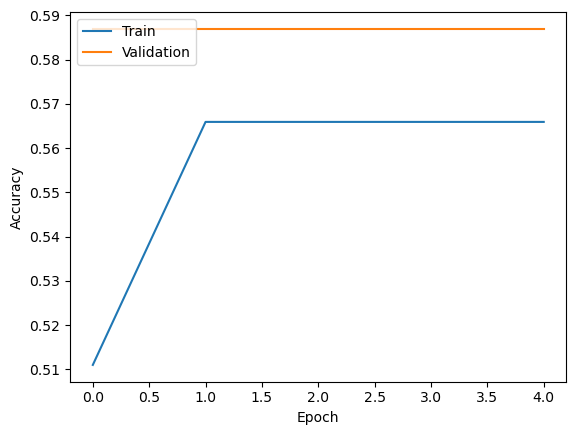

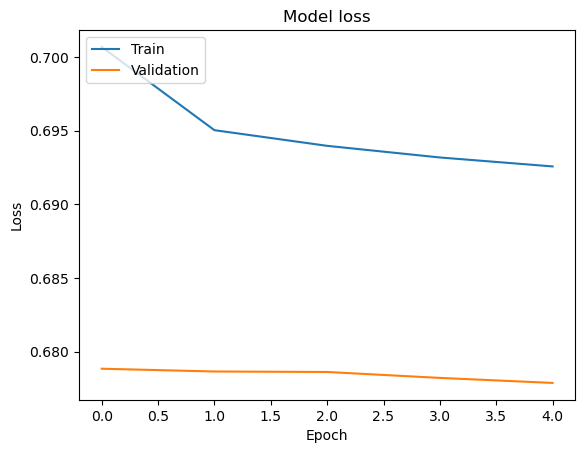

In [28]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


### Printning the results of all tests

In [37]:
results= [{'Optimizer': 'SGD (Default)',
    'Batch Size': None,  
  'Epoch': 5,
  'Learning Rate': 0.01,
  'Test Accuracy': '52.53%', 
  'Test Loss': '0.6911',
  'Train Accuracy': '59.89%',          
  'Average Train Loss': '0.6827'},
          
  {'Optimizer': 'SGD (Traditional CNN)',
      'Batch Size': None,  
  'Epoch': 5,
  'Learning Rate': 0.01,
  'Test Accuracy': '55.57%',
  'Test Loss': '0.6864',
  'Train Accuracy': '56.59%',
  'Average Train Loss': '0.6951'},       
          
 {'Optimizer': 'SGD',
  'Batch Size': 8,
  'Epoch': 5,
  'Learning Rate': 0.05,
  'Test Accuracy': '55.56%',
  'Test Loss': '0.6878',
  'Train Accuracy': '59.89%',
  'Average Train Loss': '0.6907'},
          
  {'Optimizer': 'ADAM',
  'Batch Size': 8,  
  'Epoch': 5,
  'Learning Rate': 0.05,
  'Test Accuracy': '55.56%',
  'Test Loss': '0.6877',
  'Train Accuracy': '59.89%',
  'Average Train Loss': '0.6767'},
          
  {'Optimizer': 'SGD',
    'Batch Size': 16,  
  'Epoch': 5,
  'Learning Rate': 0.1,
  'Test Accuracy': '55.55%',
  'Test Loss': '0.6900',
  'Train Accuracy': '59.89%',
  'Average Train Loss': '0.67466'},
          
  {'Optimizer': 'ADAM',
      'Batch Size': 16,  
  'Epoch': 5,
  'Learning Rate': 0.1,
  'Test Accuracy': '55.55%',
  'Test Loss': '0.6892',
  'Train Accuracy': '59.89%',
  'Average Train Loss': '0.6747'},
          
  {'Optimizer': 'SGD (Width)',
      'Batch Size': 8,  
  'Epoch': 5,
  'Learning Rate': 0.01,
  'Test Accuracy': '55.56%',
  'Test Loss': '0.6903',
  'Train Accuracy': '55.59%',
  'Average Train Loss': '2.06468'},
    
   {'Optimizer': 'SGD (Depth)',
      'Batch Size': 8,  
  'Epoch': 5,
  'Learning Rate': 0.01,
  'Test Accuracy': '56.56%',
  'Test Loss': '938.8556',
  'Train Accuracy': '55.0459%',
  'Average Train Loss': '25,561.66462'}     
  ]
     

results = pd.DataFrame(results)

print(results.to_markdown())

|    | Optimizer             |   Batch Size |   Epoch |   Learning Rate | Test Accuracy   |   Test Loss | Train Accuracy   | Average Train Loss   |
|---:|:----------------------|-------------:|--------:|----------------:|:----------------|------------:|:-----------------|:---------------------|
|  0 | SGD (Default)         |          nan |       5 |            0.01 | 52.53%          |      0.6911 | 59.89%           | 0.6827               |
|  1 | SGD (Traditional CNN) |          nan |       5 |            0.01 | 55.57%          |      0.6864 | 56.59%           | 0.6951               |
|  2 | SGD                   |            8 |       5 |            0.05 | 55.56%          |      0.6878 | 59.89%           | 0.6907               |
|  3 | ADAM                  |            8 |       5 |            0.05 | 55.56%          |      0.6877 | 59.89%           | 0.6767               |
|  4 | SGD                   |           16 |       5 |            0.1  | 55.55%          |      0.69   | 59.89%